In [1]:
import osmnx as ox
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import LineString, Point
import matplotlib.lines as mlines
import matplotlib.cm as cm
import matplotlib.colors as colors

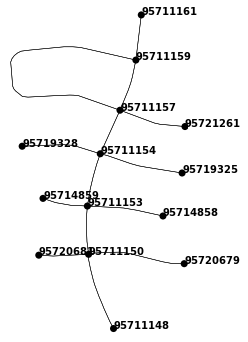

In [2]:
plt.ioff()

# Set boundaries
north, south, east, west = 38.560306, 38.554962, -121.778196, -121.782457

# load entire graph
G2 = ox.graph_from_bbox(north, south, east, west, network_type='drive')
G2.remove_edge(256194000, 95711161)
G2.remove_edge(95711161, 256194000)

fig, ax = ox.plot_graph(G2, figsize=(10, 6), node_color='k', node_size=50, edge_linewidth=0.5,edge_color='black', show=False, close=False, bgcolor='white')

for node in G2.nodes:
    #if node % 10 == 4 :#or node % 10 == 4:
        coord = ( G2.nodes[node]['x'], G2.nodes[node]['y'] )
        ax.annotate(node, xy=coord, color='black', weight='bold', size = 10)

plt.show()
plt.close('all')

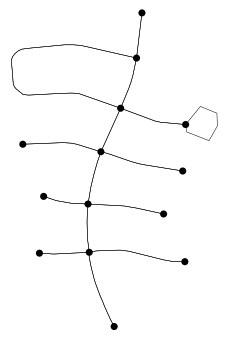

In [3]:
coords = [
    (-121.7785476, 38.5582677),
    (-121.7782631, 38.5585401),
    (-121.7779461, 38.5584381),
    (-121.7779381, 38.5582461),
    (-121.7780981, 38.5580251),
    (-121.7785271, 38.5581571),
    (-121.7785476, 38.5582677)
]


geometry =  LineString(
    [Point((x,y)) for (x,y) in coords]
)

new_edge_dat = {
    'osmid': 10745321,
    'name': 'self loop',
    'highway': 'residential',
    'oneway': False,
    'length': 50,
    'geometry': geometry
}

G2.add_edges_from([(95721261, 95721261, new_edge_dat)])

fig, ax = ox.plot_graph(G2, figsize=(10, 6), node_color='k', node_size=50,
                        edge_linewidth=0.5,edge_color='black', show=False, close=False, bgcolor='white')

plt.show()
plt.close('all')

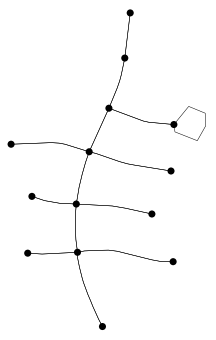

In [4]:
#multi-edges
G2.remove_edge(95711159, 95711157, 1)
G2.remove_edge(95711157, 95711159, 1)

fig, ax = ox.plot_graph(G2, figsize=(10, 6), node_color='k', node_size=50, edge_linewidth=0.5,edge_color='black', show=False, close=False, bgcolor='white')

plt.show()
plt.close('all')

In [5]:
#multi-edges
G2.remove_edge(95711159, 95711157, 1)
G2.remove_edge(95711157, 95711159, 1)

#dead-ends
G2.remove_edge(95711157, 95721261, 0)
G2.remove_edge(95721261, 95711157, 0)

G2.remove_edge(95711154, 95719328, 0)
G2.remove_edge(95719328, 95711154, 0)

G2.remove_edge(95711154, 95719325, 0)
G2.remove_edge(95719325, 95711154, 0)

G2.remove_edge(95711153, 95714859, 0)
G2.remove_edge(95714859, 95711153, 0)

G2.remove_edge(95711153, 95714858, 0)
G2.remove_edge(95714858, 95711153, 0)

G2.remove_edge(95711150, 95720681, 0)
G2.remove_edge(95720681, 95711150, 0)

G2.remove_edge(95711150, 95720679, 0)
G2.remove_edge(95720679, 95711150, 0)

fig, ax = ox.plot_graph(G2, figsize=(10, 6), node_color='k', node_size=50, edge_linewidth=0.5,edge_color='black', show=False, close=False, bgcolor='white')

plt.show()
plt.close('all')

NetworkXError: The edge 95711159-95711157 with key 1 is not in the graph.

In [ ]:
G = G2

attrs_to_sum = {"length", "travel_time"}

## Edge contraction ##
all_nodes_to_remove = []
all_edges_to_add = []

# generate each path that needs to be simplified
for path in ox.simplification._get_paths_to_simplify(G, strict=True):

    # add the interstitial edges we're removing to a list so we can retain
    # their spatial geometry
    path_attributes = dict()
    edges_in_path = []

    for u, v in zip(path[:-1], path[1:]):

        # get edge between these nodes: if multiple edges exist between
        # them (see above), we retain only one in the simplified graph
        edge_data = G.edges[u, v, 0]                
        edges_in_path.append((u,v,0))

        for attr in edge_data:
            if attr in path_attributes:
                # if this key already exists in the dict, append it to the
                # value list
                dat_val = edge_data[attr]
                if type(dat_val) == list:
                    path_attributes[attr] = path_attributes[attr] + edge_data[attr]
                else:
                    path_attributes[attr].append(edge_data[attr])
            else:
                # if this key doesn't already exist, set the value to a list
                # containing the one value
                dat_val = edge_data[attr]
                if type(dat_val) == list:
                    path_attributes[attr] = edge_data[attr]
                else:
                    path_attributes[attr] = [edge_data[attr]]

    # consolidate the path's edge segments' attribute values
    for attr in path_attributes:
        if attr in attrs_to_sum:
            # if this attribute must be summed, sum it now
            path_attributes[attr] = sum(path_attributes[attr])
        elif (attr != "geometry") and len(set(path_attributes[attr])) == 1:
            # if there's only 1 unique value in this attribute list,
            # consolidate it to the single value (the zero-th):
            path_attributes[attr] = path_attributes[attr][0]
        elif attr != "geometry":
            # otherwise, if there are multiple values, keep one of each
            path_attributes[attr] = list(set(path_attributes[attr]))

    # Check consolidated edges are all in the 'consolidated_edges'
    if 'consolidated_edges' not in path_attributes:
        # none of the edges in path is previously consolidated
        # all the exact edges in the path is added to 'consolidated edges'
        path_attributes['consolidated_edges'] = edges_in_path
    else:
        # at least one of the edges in path is previously consolidated
        # previously not consolidated edges need to be added to 'consolidated edges'
        for edge in edges_in_path:
            if edge in input_G.edges:
                path_attributes['consolidated_edges'].append(edge)

    # construct the new consolidated edge's geometry for this path
    if 'geometry' not in path_attributes:
        path_attributes["geometry"] = LineString(
            [Point((G.nodes[node]["x"], G.nodes[node]["y"])) for node in path]
        )
    else:
        points = []
        geometry = path_attributes['geometry']

        # Gather geometry dataframes in a list
        gm_df = []
        for gm in geometry:
            x,y = gm.coords.xy
            df = pd.DataFrame({'x':x,'y':y})
            gm_df.append(df)

        for node in path:
            node_x = G.nodes[node]['x']
            node_y = G.nodes[node]['y']
            node_coord = (node_x, node_y)
            node_point = Point(node_coord)
            #if node_point in points: continue

            used_df_idx = [] # Prevent using duplicate geometry in reverse=order
            node_belong_to_gm = False

            for i, df in enumerate(gm_df):
                # check if this node has geometry
                has_gm = ((df['x'] == node_x) & (df['y'] == node_y))

                # if geometry exists, add all the points in it
                if has_gm.loc[has_gm.index[0]] and i not in used_df_idx:
                    node_belong_to_gm = True
                    used_df_idx.append(i)
                    for idx, row in df.iterrows():
                        x_coord = row['x']
                        y_coord = row['y']
                        geo_point = Point((x_coord, y_coord))
                        if geo_point not in points: points.append(geo_point)
                elif has_gm.loc[has_gm.index[-1]] and i not in used_df_idx:
                    node_belong_to_gm = True
                    used_df_idx.append(i)
                    df = df[::-1]
                    for idx, row in df.iterrows():
                        x_coord = row['x']
                        y_coord = row['y']
                        geo_point = Point((x_coord, y_coord))
                        if geo_point not in points: points.append(geo_point)

            # for node without geometry, simply add its single point
            if not node_belong_to_gm:
                points.append(node_point)

        path_attributes["geometry"] = LineString(points)

    # add the nodes and edge to their lists for processing at the end
    all_nodes_to_remove.extend(path[1:-1])
    all_edges_to_add.append(
        {"origin": path[0], "destination": path[-1], "attr_dict": path_attributes}
    )

# for each edge to add in the list we assembled, create a new edge between
# the origin and destination
for edge in all_edges_to_add:
    G.add_edge(edge["origin"], edge["destination"], **edge["attr_dict"])

# finally remove all the interstitial nodes between the new edges
G.remove_nodes_from(set(all_nodes_to_remove))

fig, ax = ox.plot_graph(G, figsize=(10, 6), node_color='k', node_size=50, edge_linewidth=0.5,edge_color='black', show=False, close=False, bgcolor='white')

plt.show()
plt.close('all')